In [2]:
from psaw import PushshiftAPI
import praw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors
from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

In [3]:
creds = {}
with open ('/opt/cap1/.cap1', 'r') as fp:
    for line in fp:
        k, v = line.replace('\n','').split('\t')
        creds[k] = v

In [4]:
reddit = praw.Reddit(client_id=creds['REDDIT_ID'], 
    client_secret=creds['REDDIT_SECRET'],
    password=creds['REDDIT_PASSWORD'], 
    username=creds['REDDIT_USERNAME'],
    user_agent='accessAPI:v0.0.1 (by /u/{})'.format(creds['REDDIT_USERNAME']))

In [5]:
client = MongoClient('localhost', 27017)
db = client['cap2']
table = db['first_and_last']

In [6]:
!pwd

/home/ubuntu/src/troll_classifier


In [7]:
susp_usrs = pd.read_csv('data/user_activity_dataframe.csv')
susp_usrs.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
susp_usrs

,username,type,subreddit,count
0,BlackToLive,comment,politics,3
1,BlackToLive,submission,BlackLivesMatter,7
2,BlackToLive,submission,Bad_Cop_No_Donut,4
3,BlackToLive,submission,blackculture,3
4,BlackToLive,submission,blackpower,3
...,...,...,...,...
3820,rubinjer,submission,holdthemoan,1
3821,rubinjer,submission,michaelbaygifs,1
3822,rubinjer,submission,milf,1
3823,rubinjer,submission,nsfw_wtf,1


In [9]:
# suspicious users posted to 939 unique subreddits ... odd b/c there are 939 unique suspicious 
#  usernames on Reddit's transparency report
sub_unq = np.unique(susp_usrs['subreddit'])
len(sub_unq), sub_unq[:20]

(939,
 array(['100BlackMen', '2016_elections', '3DPorncraft', '3Dprinting',
        '4chan', '60fpsporn', 'A858DE45F56D9BC9', 'ANormalDayInAmerica',
        'ANormalDayInRussia', 'AccidentalRacism', 'AdvancedMicroDevices',
        'Advice', 'AdviceAnimals', 'Africa', 'AfricanAmerican', 'Agario',
        'AgeplayPenPals', 'AirForce', 'Alabama', 'Albuquerque'],
       dtype=object))

In [10]:
# 333 of the 939 suspicious users posted a comment or submission
usr_unq = np.unique(susp_usrs['username'])
len(usr_unq), usr_unq[:20]

(333,
 array(['1488Reasons', 'Abena_Tau', 'AdoraronDoomworker',
        'AgaluneMalordred', 'AgamagelvTozshura', 'Aiden_Chuck',
        'Albert_Baldwin', 'AlsagelvBuriron', 'Amohelang',
        'AndromajurusAragrel', 'AndrorneGavinrage', 'AragelvBlackkiller',
        'AralisTugis', 'AriundisVugar', 'AriutusMokazahn',
        'AxeseekerMightwind', 'BagoreZulkihn', 'BallardredTholak',
        'BeazerneMem', 'BerskyN'], dtype=object))

In [11]:
#### there are 939 suspicious users on Reddit's list. 939...oddly specific match 
#### to the number of unique subreddits to which the 939 accounts posted
!wc -l data/suspicious_users.txt

939 data/suspicious_users.txt


In [12]:
# would like to get the very first and the very last post/comment from each user to get the time span of the data
api = PushshiftAPI()

In [ ]:
def first_last(table, **kwargs):
    '''
    retrieve the first and last submission and comment for the user
    '''
    sort_types = ('desc', 'asc')
    kwargs['limit'] = 1
    search_types = (api.search_submissions, api.search_comments)
    for search_type in search_types:
        for sort_type in sort_types:
            kwargs['sort'] = sort_type
            gen = search_type(**kwargs)
            for g in list(gen):
                print(g.d_)
                table.insert_one(g.d_)

In [13]:
table = db['first_and_last']

In [ ]:
# this gets the first and last comment and submission for each suspicious user to get the timeframe of user activity
susp_usrs = pd.read_csv('data/user_activity_dataframe.csv')
susp_usrs.drop('Unnamed: 0', axis=1, inplace=True)
    
# first_last(author='DeusXYX')
for usr in np.unique(susp_usrs['username']):
    print(f'Author: {usr}')
    first_last(table, author=usr)
    print()

In [15]:
submissions = []
comments = []
for doc in table.find({}, {'_id': 0}):
    if 'title' in doc:
        submissions.append(doc)
    elif 'body' in doc:
        comments.append(doc)

In [16]:
print('Document counts ...')
print(f'submissions: {len(submissions)}')
print(f'comments: {len(comments)}')
print(f'total: {len(submissions) + len(comments)}')

Document counts ...
submissions: 666
comments: 298
total: 964


## we have the first and last comments and submissions for each user. How many users commented? submitted? Over what time frame?

#### I didn't initially store whether a document was a submission or comment, but we use the 'title' and 'body' keys to distinguish them. All documents accounted for, with 658 submissions and 294 comments

In [17]:
subs_df = pd.DataFrame.from_dict(submissions)
comms_df = pd.DataFrame.from_dict(comments)

In [18]:
# set the index to datetime using the timestamp in 'created_utc'
comms_df.index = [dt.fromtimestamp(x) for x in comms_df['created_utc']]
subs_df.index = [dt.fromtimestamp(x) for x in subs_df['created_utc']]

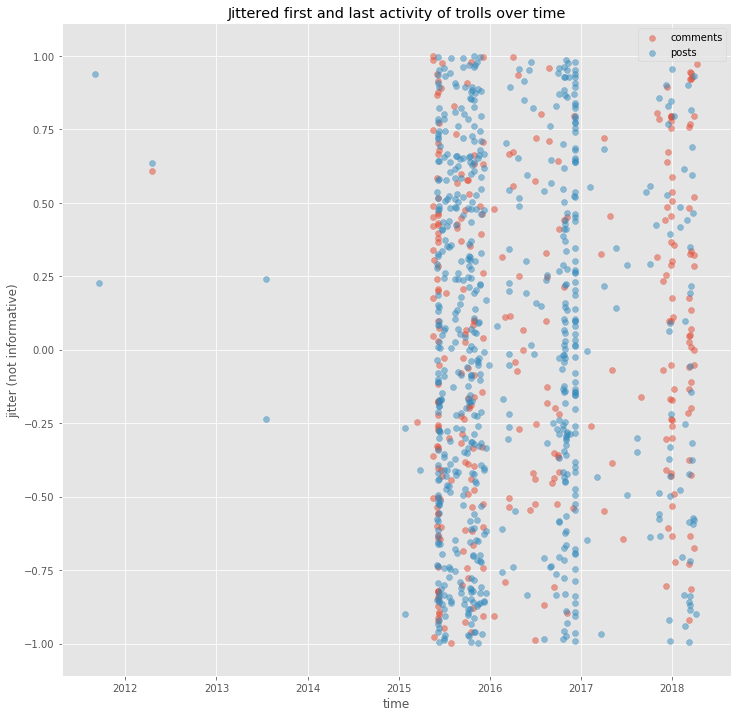

In [19]:
# show me the data!
fig, ax = plt.subplots(1, figsize=(12, 12))
dat_type = ['comments', 'posts']
for i, dat in enumerate([comms_df, subs_df]):
    range_dat = dat
    jitter = stats.uniform(-1, 2).rvs(len(range_dat))
    ax.scatter(range_dat.index, jitter, label=dat_type[i], alpha=0.5)
    ax.set_title('Jittered first and last activity of trolls over time')
ax.set_ylabel('jitter (not informative)')
ax.set_xlabel('time')
ax.legend();

#### just look at the activity leading up to the election after the action starts in 2015

In [20]:
date_start='2015-05'
date_end='2017-01'
len(comms_df[date_start:date_end])

205

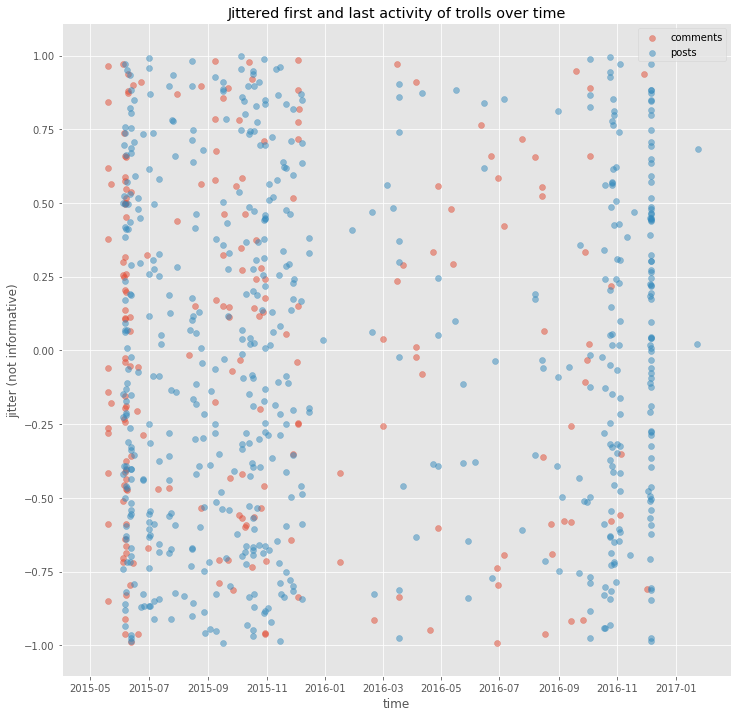

In [21]:
# show me the data!
fig, ax = plt.subplots(1, figsize=(12, 12))
dat_type = ['comments', 'posts']
for i, dat in enumerate([comms_df, subs_df]):
    range_dat = dat[date_start:date_end]
    jitter = stats.uniform(-1, 2).rvs(len(range_dat))
    ax.scatter(range_dat.index, jitter, label=dat_type[i], alpha=0.5)
    ax.set_title('Jittered first and last activity of trolls over time')
ax.set_ylabel('jitter (not informative)')
ax.set_xlabel('time')
ax.legend();

#### what do these spikes of activity look like when resampled by day/hour?

In [22]:
# HOURLY
subs_hourly = subs_df['created_utc'].resample('H').count()
comms_hourly = comms_df['created_utc'].resample('H').count()

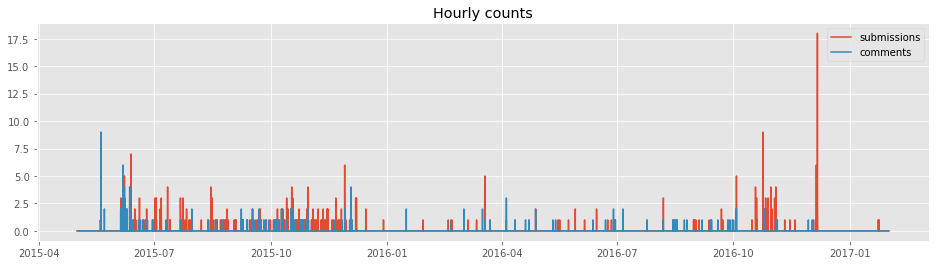

In [23]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(subs_hourly[date_start:date_end], label='submissions')
ax.plot(comms_hourly[date_start:date_end], label='comments')
ax.set_title("Hourly counts")
ax.legend()

In [24]:
# DAILY
subs_daily = subs_df['created_utc'].resample('D').count()
comms_daily = comms_df['created_utc'].resample('D').count()

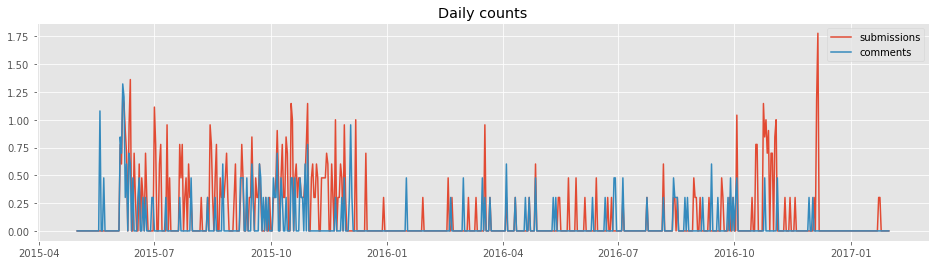

In [25]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(np.log10(subs_daily[date_start:date_end]+1), label='submissions', scaley='log')
ax.plot(np.log10(comms_daily[date_start:date_end]+1), label='comments', scaley='log')
ax.set_title("Daily counts")
ax.legend()

#### so that spike, which users and subreddits is that?

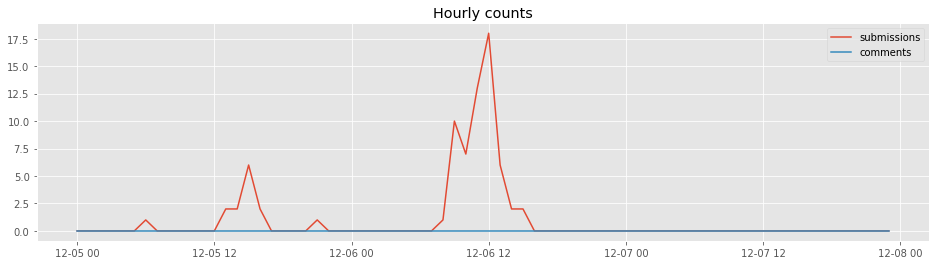

In [26]:
fig, ax = plt.subplots(1, figsize=(16, 4))

date_start, date_end = '2016-12-05', '2016-12-07'
ax.plot(subs_hourly[date_start:date_end], label='submissions')
ax.plot(comms_hourly[date_start:date_end], label='comments')
ax.set_title("Hourly counts")
ax.legend()

#### well, it happened after the election, so I'm not as interested in that, but here are functions to explore the date range, users, and subreddits

In [27]:
def timespan_activity_user_subreddit(df,
                                     fields=['author', 'subreddit'],
                                     resample_by='D',
                                     date_start=None,
                                     date_end=None,
                                     title=None):
    '''
    plot total activity, then break out by author and subreddit
    '''
    range_df = df[date_start:date_end]
    resamp_df = range_df.resample(resample_by).count()
    fig, axs = plt.subplots(3, 1, figsize=(16, 48))
    axs[0].plot(resamp_df['created_utc'].fillna(0))
    axs[0].set_title(title)
    for i, f in enumerate(fields):
        plot_strip_counts(range_df, f, axs[i+1], 
                          title=f'activity by {f}',
                          date_start=date_start,
                          date_end=date_end)

In [28]:
def plot_strip_counts(df, field, ax, title=None, date_start=None, date_end=None):
    for i, val in enumerate(np.unique(df[field])):
        filt_series = df[df[field] == val][date_start:date_end][field]
        ax.scatter(filt_series.index, filt_series, color='blue', alpha=0.25)
        ax.set_ylabel(field)
        ax.set_title(title)

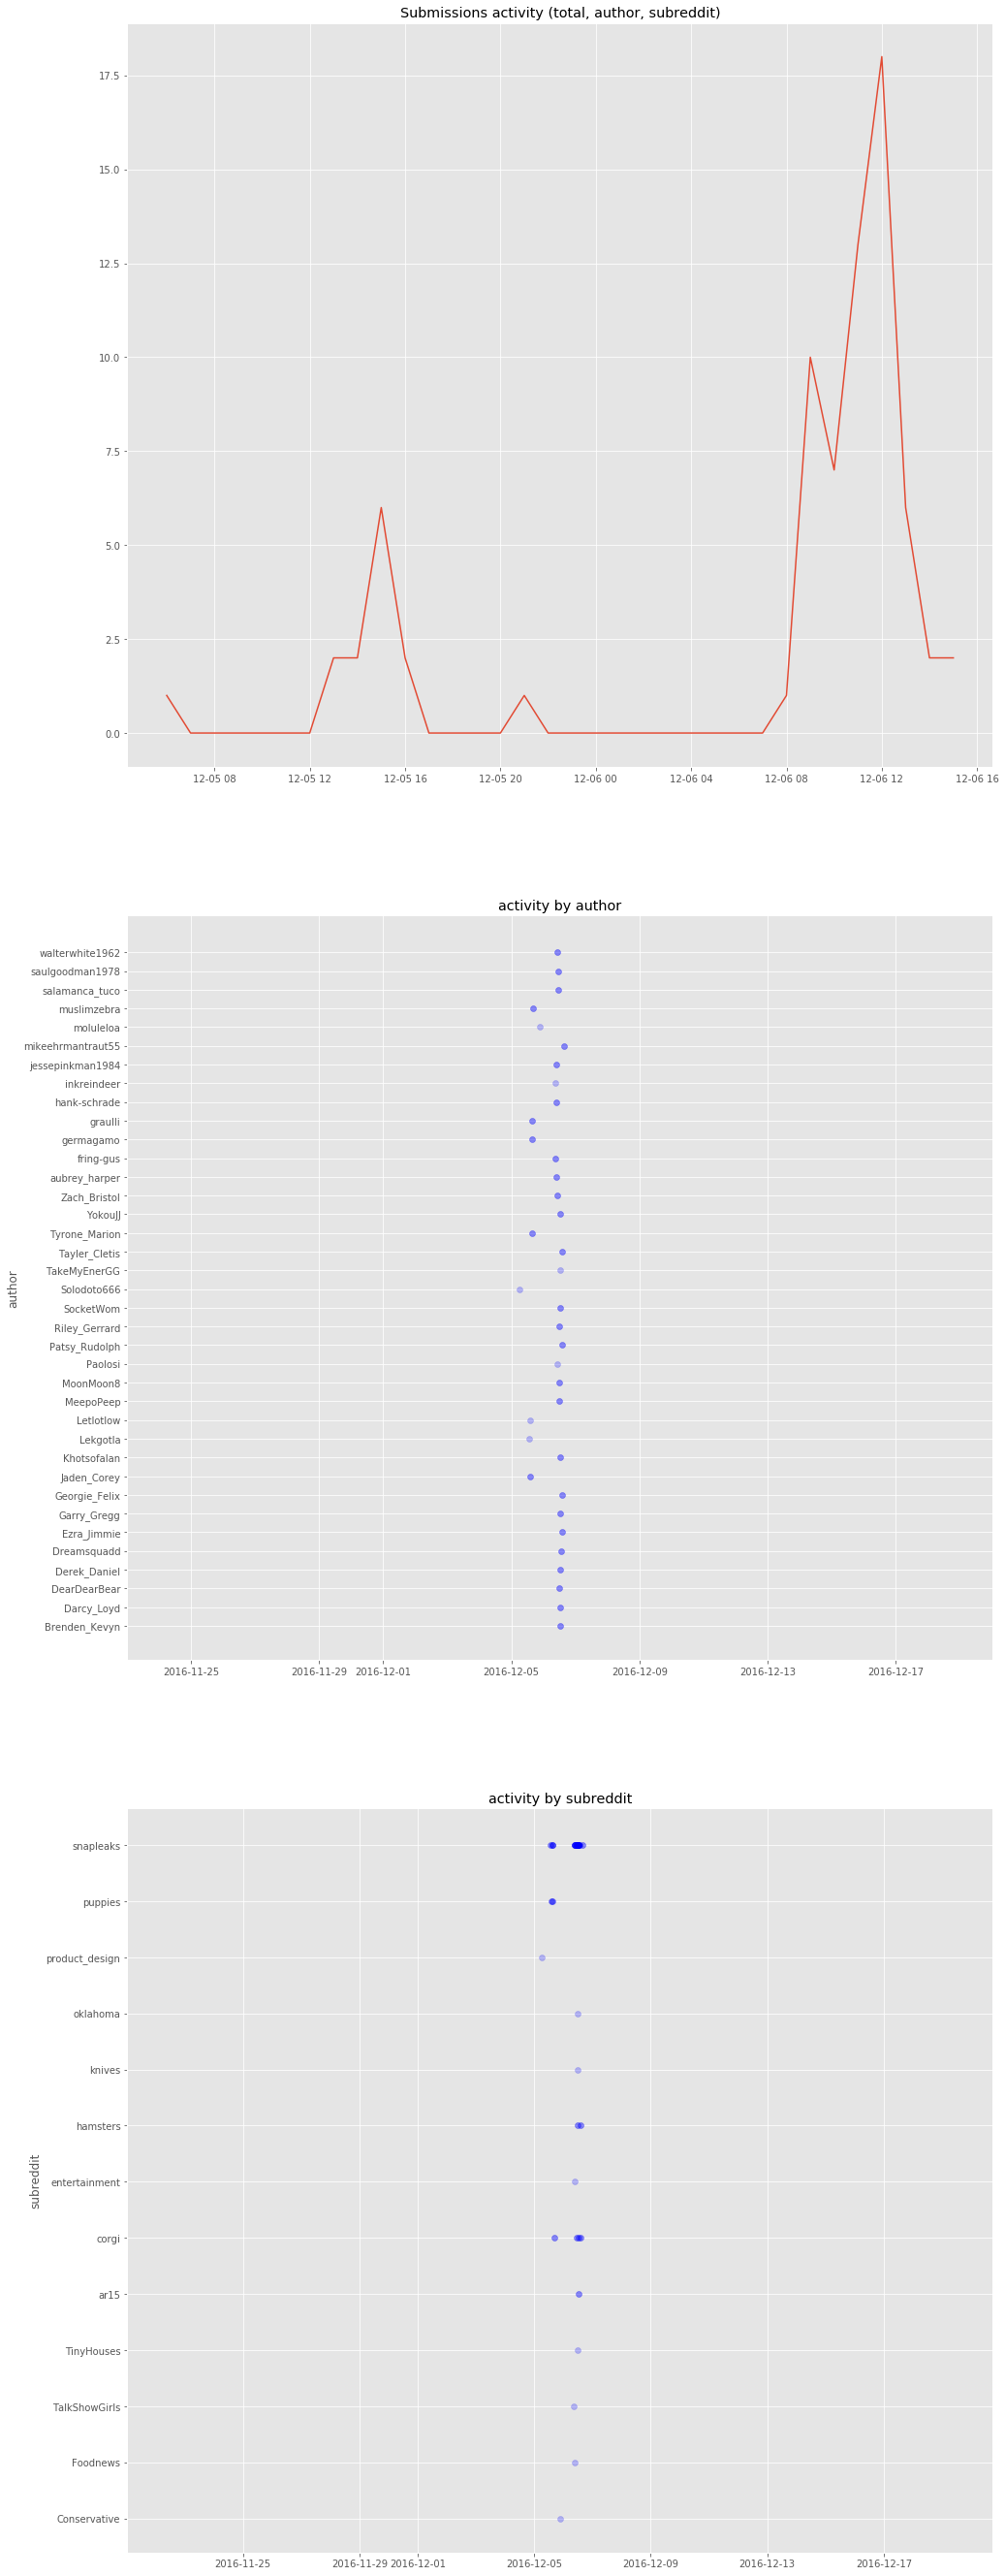

In [29]:
timespan_activity_user_subreddit(subs_df, 
                                 resample_by='H',
                                 date_start='2016-12-05',
                                 date_end='2016-12-07',
                                 title='Submissions activity (total, author, subreddit)')

#### when were the users created?

In [30]:
def plot_activity_with_jitter(ax, series, title=None, label=None):
    jitter = stats.uniform(-1, 2).rvs(len(series))
    x = [dt.fromtimestamp(x) for x in series]
    ax.scatter(x, jitter, alpha=0.5, label=label)
    ax.set_title(title)

In [31]:
comms = comms_df['author_created_utc'].dropna()
subs = subs_df['author_created_utc'].dropna()
len(comms), len(subs)

(289, 600)

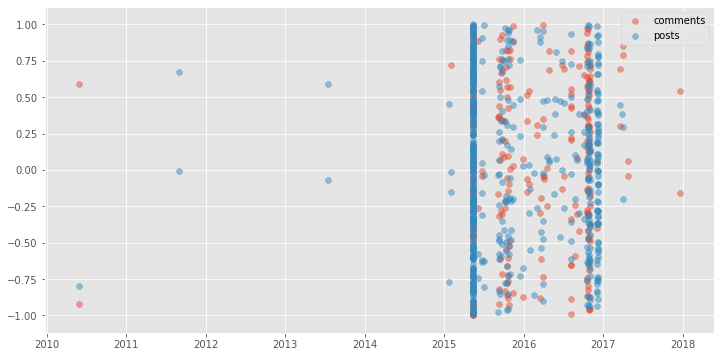

In [21]:
date_s, date_e = '2015-05', '2017-01'
fig, ax = plt.subplots(1, figsize=(12, 6))
titles = ['comments', 'posts']
for i, s in enumerate([comms, subs]):
    plot_activity_with_jitter(ax, s, label=titles[i])
ax.legend()

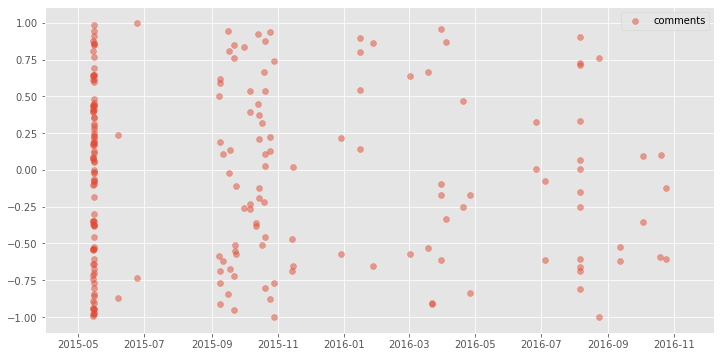

In [32]:
date_s, date_e = '2015-05', '2017-01'
fig, ax = plt.subplots(1, figsize=(12, 6))
titles = ['comments']
for i, s in enumerate([comms[date_s:date_e]]):
    plot_activity_with_jitter(ax, s, label=titles[i])
ax.legend()

#### what is the pattern of author created vs. activity?

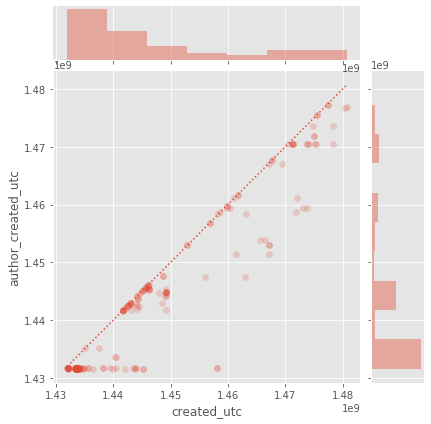

In [33]:
# lines and shading 2d density
range_df = comms_df['2015-05':'2017-01']
axs = sns.jointplot("created_utc", "author_created_utc", 
                    data=range_df, 
                    kind='scatter', 
                    alpha=0.2)
# add the x=y line for comments made immediately following acount creation
x = np.linspace(np.min(range_df['created_utc']), np.max(range_df['created_utc']), 250)
axs.ax_joint.plot(x, x, ':')

## author creation times in same thread, any similarity?

In [59]:
comms_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 298 entries, 2016-06-28 05:08:53 to 2015-05-22 13:50:56
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   author                    298 non-null    object 
 1   author_created_utc        289 non-null    float64
 2   author_flair_css_class    9 non-null      object 
 3   author_flair_text         9 non-null      object 
 4   author_fullname           256 non-null    object 
 5   body                      298 non-null    object 
 6   controversiality          256 non-null    float64
 7   created_utc               298 non-null    int64  
 8   distinguished             0 non-null      float64
 9   gilded                    256 non-null    float64
 10  id                        298 non-null    object 
 11  link_id                   298 non-null    object 
 12  nest_level                252 non-null    float64
 13  parent_id                 29

Text(0, 0.5, 'Number of threads')

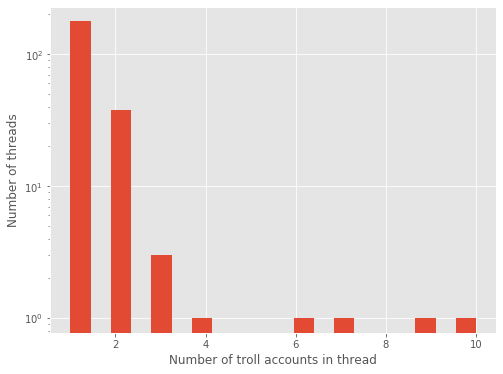

In [34]:
# list(comms_df.['link_id', 'author'], as_index=True)['author_created_utc'])
fig, ax = plt.subplots(1, figsize=(8, 6))
ax = comms_df.groupby(['link_id']).count().sort_values(by='author', ascending=False)['author'].hist(ax=ax, bins=20, log=True)
# comms_df[['id', 'link_id', 'author','author_created_utc']]
ax.set_xlabel('Number of troll accounts in thread')
ax.set_ylabel('Number of threads')

In [35]:
len(np.unique(comms_df['link_id']))

223

In [36]:
# mask = comms_df['link_id'] == 't3_7m1hht'

mask = comms_df['link_id'] == 't3_36j690'

In [37]:
for comment in comms_df[mask.values].items():
    print(comment)

('author', 2015-05-19 19:55:26      AxeseekerMightwind
2015-05-19 19:55:26      AxeseekerMightwind
2015-05-19 19:56:57               DarusCege
2015-05-19 19:56:57               DarusCege
2015-05-19 19:58:06         GavinraraFonara
2015-05-19 19:58:06         GavinraraFonara
2015-05-19 19:56:54    VanecedwaShadowsmith
2015-05-19 19:56:54    VanecedwaShadowsmith
2015-05-19 19:56:06             ZuluraGolar
Name: author, dtype: object)
('author_created_utc', 2015-05-19 19:55:26    1.431695e+09
2015-05-19 19:55:26    1.431695e+09
2015-05-19 19:56:57    1.431695e+09
2015-05-19 19:56:57    1.431695e+09
2015-05-19 19:58:06    1.431685e+09
2015-05-19 19:58:06    1.431685e+09
2015-05-19 19:56:54    1.431614e+09
2015-05-19 19:56:54    1.431614e+09
2015-05-19 19:56:06    1.431687e+09
Name: author_created_utc, dtype: float64)
('author_flair_css_class', 2015-05-19 19:55:26    None
2015-05-19 19:55:26    None
2015-05-19 19:56:57    None
2015-05-19 19:56:57    None
2015-05-19 19:58:06    None
2015-05-

### visualize heatmap of subreddit comment and post activity by trolls

# see https://stackoverflow.com/questions/27988846/how-to-express-classes-on-the-axis-of-a-heatmap-in-seaborn

In [38]:
networks = sns.load_dataset("brain_networks", index_col=0, header=[0, 1, 2])

### network level

In [39]:
network_labels = networks.columns.get_level_values("network")
network_pal = sns.cubehelix_palette(network_labels.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
network_lut = dict(zip(map(str, network_labels.unique()), network_pal))

#### Create index using the columns for networks

In [40]:
network_colors = pd.Series(network_labels, index=networks.columns).map(network_lut)

### node level

In [41]:
node_labels = networks.columns.get_level_values("node")
node_pal = sns.cubehelix_palette(node_labels.unique().size)
node_lut = dict(zip(map(str, node_labels.unique()), node_pal))

#### Create index using the columns for nodes

In [42]:
node_colors = pd.Series(node_labels, index=networks.columns).map(node_lut)

#### Create dataframe for row and column color levels

In [43]:
network_node_colors = pd.DataFrame(network_colors).join(pd.DataFrame(node_colors))

### create clustermap

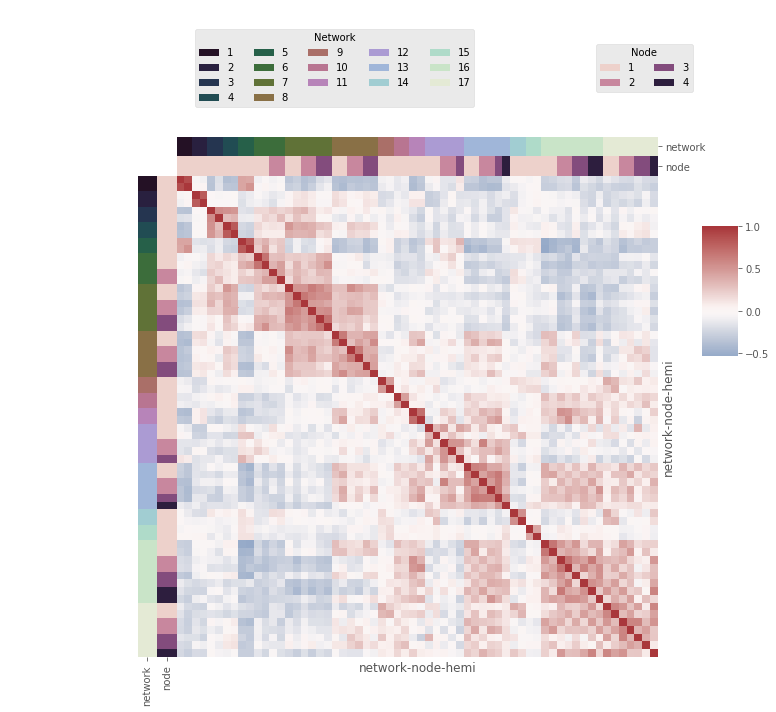

In [44]:
g = sns.clustermap(networks.corr(),
    # Turn off the clustering
    row_cluster=False, col_cluster=False,
    # Add colored class labels using data frame created from node and network colors
    row_colors = network_node_colors,
    col_colors = network_node_colors,
    # Make the plot look better when many rows/cols
    linewidths=0,
    xticklabels=False, yticklabels=False,
    cbar_pos=(0.98, 0.5, 0.05, 0.18),
    center=0, cmap="vlag")

### create two legends - one for each level by creating invisible column and row barplots (as per above)
#### network legend

for label in network_labels.unique():
    g.ax_col_dendrogram.bar(0, 0, color=network_lut[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='Network', loc="center", ncol=5, bbox_to_anchor=(0.47, 0.9), bbox_transform=plt.gcf().transFigure)

#### node legend

for label in node_labels.unique():
    g.ax_row_dendrogram.bar(0, 0, color=node_lut[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Node', loc="center", ncol=2, bbox_to_anchor=(0.9, 0.9), bbox_transform=plt.gcf().transFigure)

plt.show()

In [43]:
# network_labels = networks.columns.get_level_values("network")
network_labels

Index(['1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '6', '6',
       '7', '7', '7', '7', '7', '7', '8', '8', '8', '8', '8', '8', '9', '9',
       '10', '10', '11', '11', '12', '12', '12', '12', '12', '13', '13', '13',
       '13', '13', '13', '14', '14', '15', '15', '16', '16', '16', '16', '16',
       '16', '16', '16', '17', '17', '17', '17', '17', '17', '17'],
      dtype='object', name='network')

In [51]:
# let's say that the networks will be the subreddits, and the nodes will be the users
susp_usrs['log_count'] = np.log(susp_usrs['count'])

In [54]:
# looking at overall activity from pushshift user activity agg
comments_susp_usrs = susp_usrs[susp_usrs['type']=='comment']
comments_susp_usrs.head()

,username,type,subreddit,count,log_count
0,BlackToLive,comment,politics,3,1.098612
15,FaurnFlamebreaker,comment,worldnews,4,1.386294
17,bill_jonson,comment,Documentaries,1,0.000000
21,clawisma,comment,funny,2,0.693147
22,clawisma,comment,aww,1,0.000000


In [159]:
# do the pivot
pivot_comments_susp_users = pd.pivot_table(comments_susp_usrs, values='log_count', index='username', columns='subreddit').fillna(0)

In [160]:
pivot_comments_susp_users.shape

(147, 584)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


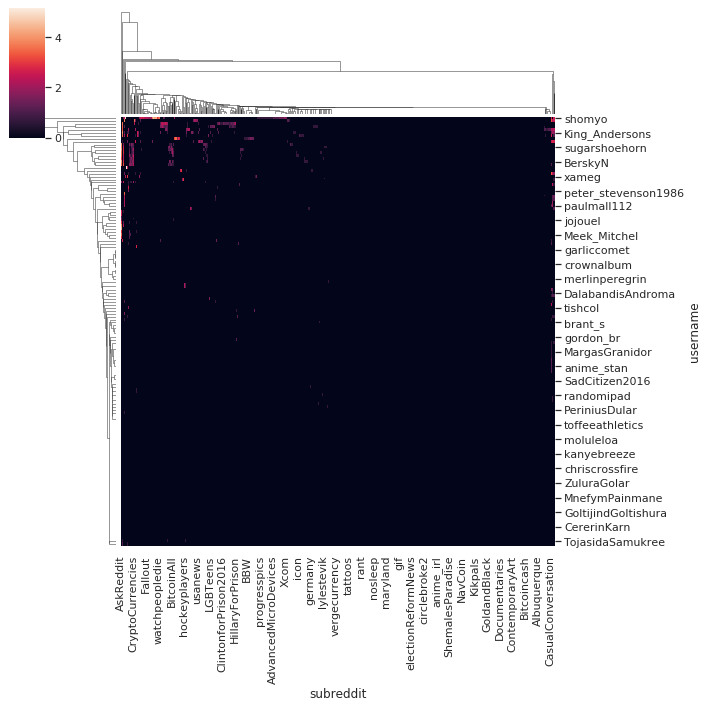

In [161]:
sns.set(color_codes=True)
g = sns.clustermap(pivot_comments_susp_users)

In [166]:
from sklearn.feature_selection import VarianceThreshold
# X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
X = pivot_comments_susp_users.values
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# sel = VarianceThreshold()
sel.fit(X)
vars(sel)

{'threshold': 0.15999999999999998,
 'variances_': array([0.        , 0.        , 0.01298462, 0.        , 0.        ,
        0.        , 0.00324615, 0.0216909 , 0.        , 0.03884889,
        0.        , 0.        , 0.        , 0.00324615, 0.00324615,
        0.01298462, 0.02099834, 0.        , 0.02064405, 0.00815468,
        0.03582198, 0.01133036, 0.        , 0.        , 0.        ,
        0.02856461, 0.        , 0.00324615, 1.4333167 , 0.01614183,
        0.01614183, 0.        , 0.00324615, 0.00324615, 0.        ,
        0.00324615, 0.        , 0.47721856, 0.        , 0.01298462,
        0.44754638, 0.06425207, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00324615, 0.02482211, 0.07791495, 0.        , 0.00324615,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02412893, 0.        , 0.01133036, 0.00815468, 0.00324615,
        0.00324615, 0.        , 0.        , 0.        , 0.03261873,

In [167]:
np.argwhere(sel.variances_ > sel.threshold).reshape(-1)

array([ 28,  37,  40,  87,  88, 256, 289, 309, 378, 389, 457, 459, 480,
       485, 489, 581])

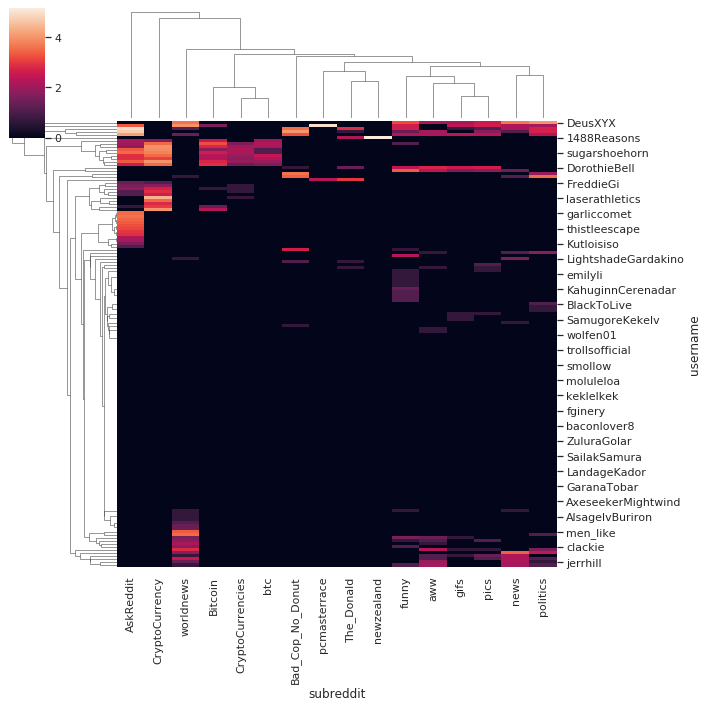

In [170]:
feature_selection_index = np.argwhere(sel.variances_ > sel.threshold).reshape(-1)
slimcol_pivot_comments_susp_users = pivot_comments_susp_users.iloc[:, feature_selection_index]
g = sns.clustermap(slimcol_pivot_comments_susp_users)

In [171]:
X = slimcol_pivot_comments_susp_users.T.values
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# sel = VarianceThreshold()
sel.fit(X)
vars(sel)

{'threshold': 0.15999999999999998,
 'variances_': array([1.7504581 , 0.11260618, 0.02815154, 0.        , 0.        ,
        0.        , 0.07071967, 1.90327912, 0.07071967, 0.        ,
        0.        , 0.29913177, 0.        , 0.        , 0.28287866,
        2.5163328 , 1.23057669, 0.11260618, 0.1714274 , 0.        ,
        0.        , 0.        , 1.527638  , 1.65335357, 0.29591287,
        0.07319401, 0.11260618, 0.02815154, 0.07071967, 0.07071967,
        0.9309624 , 0.02815154, 2.23230355, 0.        , 0.02815154,
        0.15177483, 0.        , 0.        , 0.        , 0.17121092,
        2.3717812 , 0.02815154, 0.05254955, 0.02815154, 0.02815154,
        1.90175925, 0.71634171, 0.36427096, 0.        , 0.70378859,
        0.        , 0.02815154, 1.33130896, 0.58371595, 0.        ,
        0.02815154, 0.        , 0.02815154, 0.        , 0.        ,
        0.67782092, 0.02815154, 0.05254955, 0.        , 0.        ,
        0.09292199, 0.        , 0.        , 0.        , 0.        ,

In [172]:
np.argwhere(sel.variances_ > sel.threshold).reshape(-1)

array([  0,   7,  11,  14,  15,  16,  18,  22,  23,  24,  30,  32,  39,
        40,  45,  46,  47,  49,  52,  53,  60,  74,  76,  78,  79,  81,
        84,  85,  88,  90,  91,  92,  96,  97,  98, 100, 101, 105, 107,
       109, 113, 114, 115, 116, 117, 118, 121, 124, 126, 131, 132, 135,
       137, 140, 144, 146])

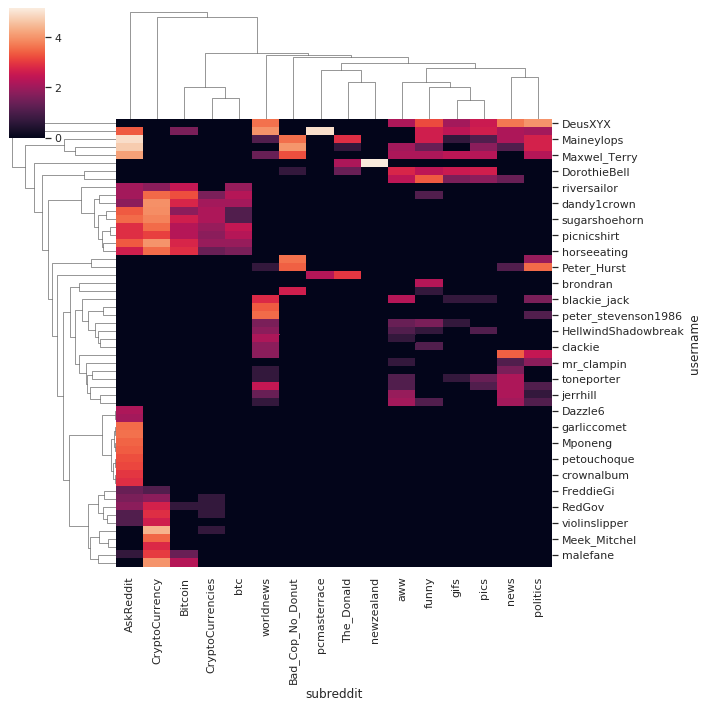

In [173]:
feature_selection_index = np.argwhere(sel.variances_ > sel.threshold).reshape(-1)
slimrow_slimcol_pivot_comments_susp_users = slimcol_pivot_comments_susp_users.T.iloc[:, feature_selection_index].T
g = sns.clustermap(slimrow_slimcol_pivot_comments_susp_users)

In [176]:
slimrow_slimcol_pivot_comments_susp_users.shape

(56, 16)

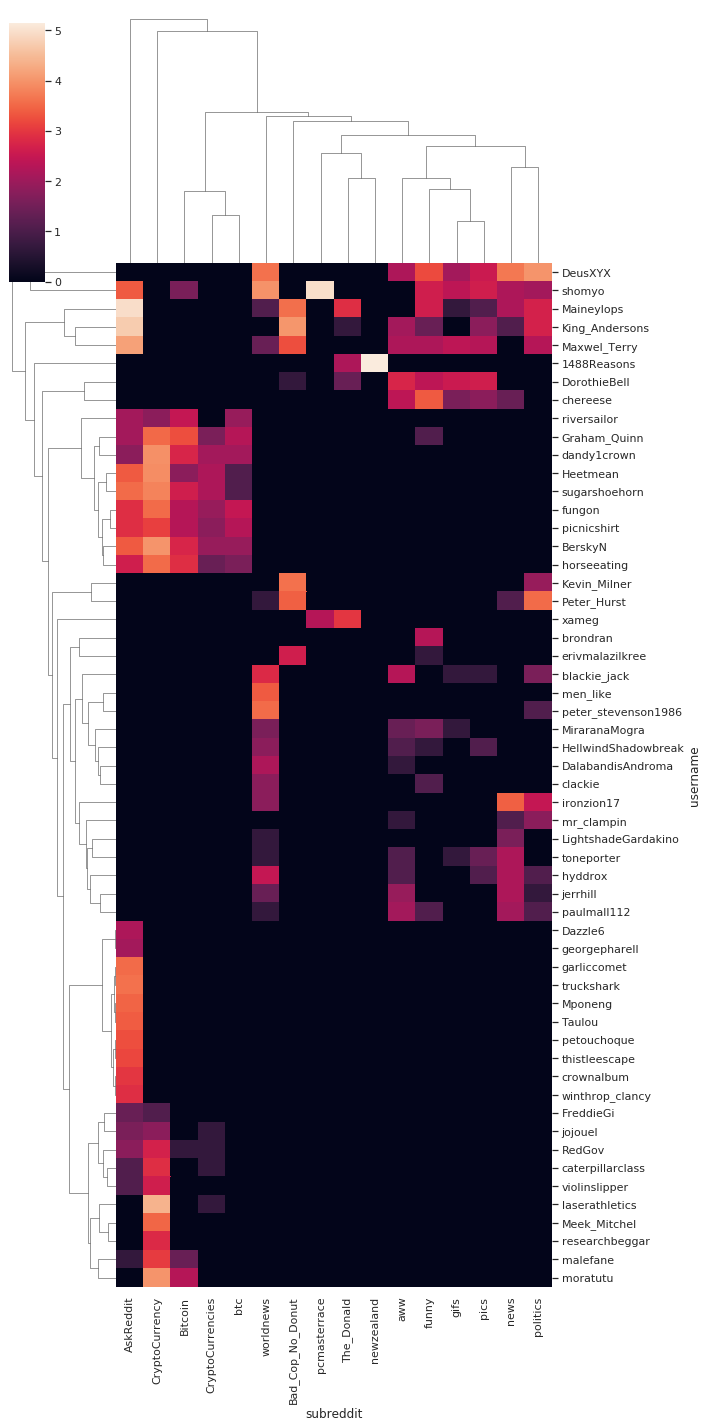

In [180]:
feature_selection_index = np.argwhere(sel.variances_ > sel.threshold).reshape(-1)
slimrow_slimcol_pivot_comments_susp_users = slimcol_pivot_comments_susp_users.T.iloc[:, feature_selection_index].T
g = sns.clustermap(slimrow_slimcol_pivot_comments_susp_users, figsize=(10, 20))

In [131]:
from sklearn.feature_selection import VarianceThreshold
from scipy import stats

def modal_0_nonmodal_1(v):
    '''
    sets values in X to 0 if value==mode(X), otherwise 1
    '''
    mode_result = stats.mode(v)
    zeros_index = (v == mode_result.mode)
    v[zeros_index] = 0
    v[~zeros_index] = 1
    return v

def vect_fun(X, fun, **kwargs):
    '''
    convenient if you want to force a function to
        accept a matrix when it would not perform
        as expected otherwise
        
    input: numpy array (n, m)
    fun: function expecting an input vector (numpy array)
    output: numpy array (n, m) after vector operations
    '''
    orig_shape = X.shape
    vect = X.reshape(-1)
    return fun(vect, **kwargs).reshape(orig_shape)

def index_feat_by_percent_nonmodal(X, threshold=0.8):
    '''
    Filters X for features with at least threshold*100 % non-modal values
    
    X: numpy array
    threshold: at least this % of values must be non-modal
    
    returns X, potentially with low-variance features removed
    '''
    binary_X = vect_fun(X, modal_0_nonmodal_1)

    t = threshold * (1 - threshold)
    vt = VarianceThreshold(threshold=t)
    vt.fit(binary_X)
    return np.argwhere(vt.variances_ > vt.threshold).reshape(-1)

def filt_dimension_by_variance(X, **kwargs):
    '''
    feature selection
      keeps only those features with variance above conceptual threshold
    
    X: numpy array
    
    parameters
      kind: either 'absolute' or 'percentage' (str)
        - absolute: TODO: rank features by variance and keep top (1-threshold)*100 %
        - percentage: keeps a feature only if at least threshold*100 % of the
          values are non-modal
      threshold: interpreted differently depending on kind (float)
    '''
    kind = kwargs['kind']
    t = kwargs['threshold'] * (1 - kwargs['threshold'])
    
    
    if kwargs['kind'] == 'percentage':
        return index_feat_by_percent_nonmodal(X, threshold=t)
    
    if kind == 'absolute':
        # not implemented yet
        raise

def filt_rows_features_by_variance(df, kind='percentage', threshold=0.8):

    # TODO: allow separate thresholds for rows and columns
    cols_t = threshold
    rows_t = threshold
    
    keep_cols = filt_dimension_by_variance(
                    df.values, 
                    kind='percentage', 
                    threshold=cols_t)
    print(df.iloc[:, keep_cols])

    keep_rows = list(range(len(df)))
#     keep_rows = filt_dimension_by_variance(
# #                     df.values.T, 
#                     df.iloc[:, keep_cols].values.T,
#                     kind='percentage', 
#                     threshold=rows_t)
    
    return df.iloc[keep_rows, keep_cols]

In [132]:
feature_reduced = filt_rows_features_by_variance(
                    pivot_comments_susp_users)

subreddit            AskReddit  funny  worldnews
username                                        
1488Reasons                0.0    0.0        0.0
AdoraronDoomworker         0.0    0.0        1.0
AlsagelvBuriron            0.0    0.0        1.0
AndromajurusAragrel        0.0    0.0        0.0
AriundisVugar              0.0    0.0        0.0
...                        ...    ...        ...
wadeharriot                0.0    0.0        0.0
waeqxd                     0.0    0.0        0.0
winthrop_clancy            1.0    0.0        0.0
wolfen01                   0.0    0.0        0.0
xameg                      0.0    0.0        0.0

[147 rows x 3 columns]


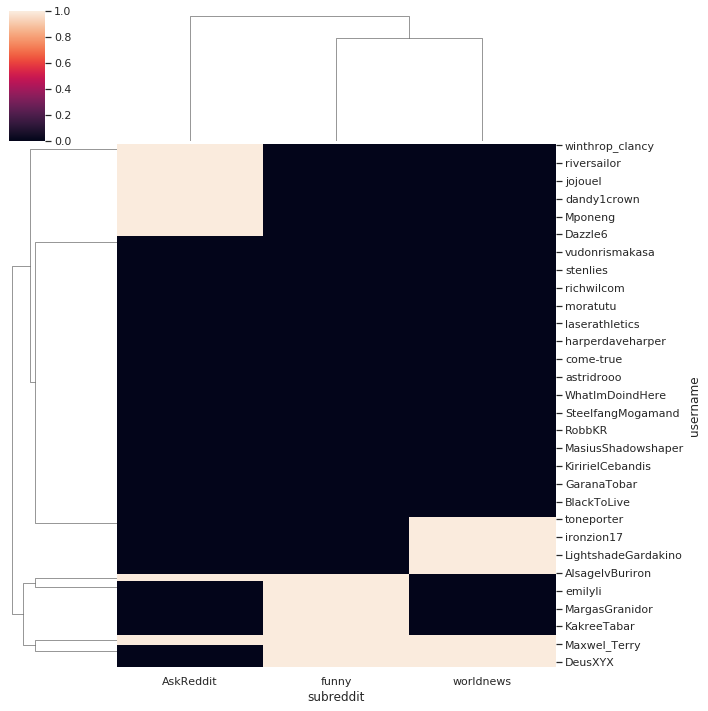

In [133]:
g = sns.clustermap(feature_reduced)

In [74]:
.8 * (1 - .8)

0.15999999999999998

In [44]:
# network_pal = sns.cubehelix_palette(network_labels.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
network_pal

[[0.14250609166695374, 0.06696404307500585, 0.14344253747283972],
 [0.16155595934115108, 0.12444369703732092, 0.2466464947085397],
 [0.14490368795926326, 0.2065088491953011, 0.31535170401288914],
 [0.1285992257028432, 0.29967426422747695, 0.32357022202263963],
 [0.15032152486952025, 0.3756120303785364, 0.28483176769910223],
 [0.23620049823315173, 0.42844599401601735, 0.23069205631078665],
 [0.378371563830964, 0.44553789451608256, 0.21473665337039155],
 [0.5381478534618528, 0.4397533771843333, 0.2734683932550487],
 [0.6656111186385743, 0.43635006390944575, 0.40755477466353185],
 [0.7234718558513549, 0.45695406637490565, 0.5670486304505923],
 [0.717640012906113, 0.5165548651039193, 0.726734835696926],
 [0.6694671741276111, 0.60879824611575, 0.8268127869297095],
 [0.6267068736639345, 0.7124215003888157, 0.8510913809212952],
 [0.6305167236407697, 0.8023909287392934, 0.8215947703283651],
 [0.6875219312333126, 0.8596527799610639, 0.7868013832755658],
 [0.7896401936423323, 0.8948250122495803,

In [45]:
#network_lut = dict(zip(map(str, network_labels.unique()), network_pal))
network_lut

{'1': [0.14250609166695374, 0.06696404307500585, 0.14344253747283972],
 '2': [0.16155595934115108, 0.12444369703732092, 0.2466464947085397],
 '3': [0.14490368795926326, 0.2065088491953011, 0.31535170401288914],
 '4': [0.1285992257028432, 0.29967426422747695, 0.32357022202263963],
 '5': [0.15032152486952025, 0.3756120303785364, 0.28483176769910223],
 '6': [0.23620049823315173, 0.42844599401601735, 0.23069205631078665],
 '7': [0.378371563830964, 0.44553789451608256, 0.21473665337039155],
 '8': [0.5381478534618528, 0.4397533771843333, 0.2734683932550487],
 '9': [0.6656111186385743, 0.43635006390944575, 0.40755477466353185],
 '10': [0.7234718558513549, 0.45695406637490565, 0.5670486304505923],
 '11': [0.717640012906113, 0.5165548651039193, 0.726734835696926],
 '12': [0.6694671741276111, 0.60879824611575, 0.8268127869297095],
 '13': [0.6267068736639345, 0.7124215003888157, 0.8510913809212952],
 '14': [0.6305167236407697, 0.8023909287392934, 0.8215947703283651],
 '15': [0.6875219312333126, 0

In [46]:
#node_colors = pd.Series(node_labels, index=networks.columns).map(node_lut)
node_colors

network  node  hemi
1        1     lh      [0.9312692223325372, 0.8201921796082118, 0.797...
               rh      [0.9312692223325372, 0.8201921796082118, 0.797...
2        1     lh      [0.9312692223325372, 0.8201921796082118, 0.797...
               rh      [0.9312692223325372, 0.8201921796082118, 0.797...
3        1     lh      [0.9312692223325372, 0.8201921796082118, 0.797...
                                             ...                        
17       2     lh      [0.7840440880599453, 0.5292660544265891, 0.620...
               rh      [0.7840440880599453, 0.5292660544265891, 0.620...
         3     lh      [0.5151069036855755, 0.29801047535056074, 0.49...
               rh      [0.5151069036855755, 0.29801047535056074, 0.49...
         4     lh      [0.1750865648952205, 0.11840023306916837, 0.24...
Name: node, Length: 62, dtype: object

In [47]:
#network_node_colors = pd.DataFrame(network_colors).join(pd.DataFrame(node_colors))
network_node_colors

network  \
network node hemi                                                      
1       1    lh    [0.14250609166695374, 0.06696404307500585, 0.1...   
             rh    [0.14250609166695374, 0.06696404307500585, 0.1...   
2       1    lh    [0.16155595934115108, 0.12444369703732092, 0.2...   
             rh    [0.16155595934115108, 0.12444369703732092, 0.2...   
3       1    lh    [0.14490368795926326, 0.2065088491953011, 0.31...   
...                                                              ...   
17      2    lh    [0.8955408221495149, 0.9180142943633274, 0.833...   
             rh    [0.8955408221495149, 0.9180142943633274, 0.833...   
        3    lh    [0.8955408221495149, 0.9180142943633274, 0.833...   
             rh    [0.8955408221495149, 0.9180142943633274, 0.833...   
        4    lh    [0.8955408221495149, 0.9180142943633274, 0.833...   

                                                                node  
network node hemi                                                     
1       1    lh    [0.9312692223325372, 0.8201921796082118, 0.797...  
             rh    [0.9312692223325372, 0.8201921796082118, 0.797...  
2       1    lh    [0.9312692223325372, 0.8201921796082118, 0.797...  
             rh    [0.9312692223325372, 0.8201921796082118, 0.797...  
3       1    lh    [0.9312692223325372, 0.8201921796082118, 0.797...  
...                                                              ...  
17      2    lh    [0.7840440880599453, 0.5292660544265891, 0.620...  
             rh    [0.7840440880599453, 0.5292660544265891, 0.620...  
        3    lh    [0.5151069036855755, 0.29801047535056074, 0.49...  
             rh    [0.5151069036855755, 0.29801047535056074, 0.49...  
        4    lh    [0.1750865648952205, 0.11840023306916837, 0.24...  

[62 rows x 2 columns]

In [ ]:
pd.DataFrame.copy()

In [ ]:
np.m

In [112]:
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 7], [2, 5, 7], [1, 7, 9]])
vect_X = X.reshape(-1,)

In [87]:
np.where(vect_X != stats.mode(vect_X), np.ones(len(vect_X)), np.zeros(len(vect_X))).reshape(X.shape)

ValueError: cannot reshape array of size 30 into shape (5,3)

In [97]:
vect_X != stats.mode(vect_X)

array([[ True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True, False,  True, False,  True],
       [ True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]])

In [98]:
a = np.array([[6, 8, 3, 0],
              [3, 2, 1, 7],
              [8, 1, 8, 4],
              [5, 3, 0, 5],
              [4, 7, 5, 9]])
stats.mode(a)

ModeResult(mode=array([[3, 1, 0, 0]]), count=array([[1, 1, 1, 1]]))

In [115]:
mode_result = stats.mode(vect_X)
zeros_index = vect_X == mode_result.mode
vect_X[zeros_index] = 0
vect_X[~zeros_index] = 1
vect_X.reshape(X.shape)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 1, 1],
       [0, 0, 1],
       [0, 1, 0]])

In [111]:
ones_index

array([False,  True, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True, False])